In [1]:
pip install datasets torchaudio jiwer transformers==4.51.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import os
from datasets import load_dataset
from jiwer import cer
import numpy as np
from transformers import (
    WhisperForConditionalGeneration,
    WhisperProcessor,
    WhisperTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    TrainerCallback
)

2025-05-22 05:29:56.347894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747891796.371708     148 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747891796.378734     148 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load dataset
dataset = load_dataset(
    "parquet",
    data_files={"full": "/kaggle/input/svarah-parquet-3000/phonemes_dataset.parquet"},
    split="full"
)

# Load the tokenizer
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny")

# Filter based on token length
filtered_dataset = dataset.filter(lambda row: len(tokenizer(row["phonemes"]).input_ids) <= 448)

print(f"Filtered dataset length: {len(filtered_dataset)}")


Filter:   0%|          | 0/3000 [00:00<?, ? examples/s]

Filtered dataset length: 2992


In [4]:
dataset = filtered_dataset.train_test_split(test_size=0.1, seed=42)

train_dataset = dataset["train"]
test_dataset = dataset["test"]

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 2692
Testing samples: 300


In [5]:
# Load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
print("Pad token ID:", processor.tokenizer.pad_token_id)
print("EOS token ID:", processor.tokenizer.eos_token_id)

Pad token ID: 50257
EOS token ID: 50257


In [6]:
# Load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
# from transformers import WhisperTokenizer

# Only do this once during tokenizer setup
processor.tokenizer.pad_token = "<|pad|>"
processor.tokenizer.add_tokens(["<|pad|>"])
processor.tokenizer.pad_token_id = processor.tokenizer.convert_tokens_to_ids("<|pad|>")

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")

model.config.condition_on_previous_text = False

# In Whisper, the encoder is actually named 'model.encoder'
# Freeze encoder parameters completely (preserves audio processing)
for param in model.model.encoder.parameters():
    param.requires_grad = False

# Freeze lower layers of decoder, only fine-tune upper layers
# For whisper-tiny with 4 layers, this freezes layers 0, 1, and fine-tunes 2, 3
num_decoder_layers = len(model.model.decoder.layers)
num_layers_to_freeze = int(0.7 * num_decoder_layers)  # Freeze 70% of layers

for i, layer in enumerate(model.model.decoder.layers):
    if i < num_layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False
            
# Print summary of what's frozen vs trainable
total_params = 0
trainable_params = 0
for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
        
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")

Total parameters: 37,760,640
Trainable parameters: 24,820,608 (65.73%)


In [7]:
print("Pad token ID:", processor.tokenizer.pad_token_id)
print("EOS token ID:", processor.tokenizer.eos_token_id)

Pad token ID: 51865
EOS token ID: 50257


In [8]:
def preprocess_function(batch):
    result = processor(
        batch["waveform"],
        sampling_rate=16000,
        text=batch["phonemes"],
        return_tensors="pt"
    )
    return {
        "input_features": result["input_features"][0],
        "labels": result["labels"][0]
    }

processed_train = train_dataset.map(preprocess_function, remove_columns=train_dataset.column_names)
processed_test = test_dataset.map(preprocess_function, remove_columns=test_dataset.column_names)


Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [9]:
class WhisperPhonemeDataCollator:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, features):
        import torch

        # Convert input_features (still lists) to tensors
        input_features = torch.tensor([f["input_features"] for f in features], dtype=torch.float32)

        # Tokenize and pad label sequences
        label_features = [{"input_ids": f["labels"]} for f in features]
        padded_labels = self.processor.tokenizer.pad(
            label_features,
            padding=True,
            return_tensors="pt"
        )

        labels = padded_labels["input_ids"]
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {
            "input_features": input_features,
            "labels": labels
        }

data_collator = WhisperPhonemeDataCollator(processor)


In [10]:
class EvalLossPrinterCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            loss = metrics.get("eval_loss", None)
            cer = metrics.get("cer", None)  # Changed from wer to cer

            if loss is not None and cer is not None:
                print(f"[Eval Step {state.global_step}] Eval Loss: {loss:.4f} | CER: {cer:.4f}")
            elif loss is not None:
                print(f"[Eval Step {state.global_step}] Eval Loss: {loss:.4f}")
            elif cer is not None:
                print(f"[Eval Step {state.global_step}] CER: {cer:.4f}")

        torch.cuda.empty_cache()


In [11]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Convert -100 in labels to tokenizer.pad_token_id so we can decode correctly
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Strip whitespace and truncate to safe length
    decoded_preds = [pred.strip()[:1024] for pred in decoded_preds]
    decoded_labels = [label.strip()[:1024] for label in decoded_labels]

    return {
        "cer": cer(decoded_labels, decoded_preds)
    }

In [12]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-phoneme-finetune",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=1e-4,
    num_train_epochs=5,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    fp16=True,
    gradient_checkpointing=True,
    save_total_limit=2,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=100,
    report_to=["tensorboard"],
    eval_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    predict_with_generate=True
)


In [13]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_train,
    eval_dataset=processed_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EvalLossPrinterCallback()],
)


In [14]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Cer
100,1.237100,0.644992,0.541445
200,0.520500,0.492757,0.348599
300,0.390800,0.437939,0.342447
400,0.299600,0.419160,0.330918
500,0.260800,0.393988,0.311460
600,0.186500,0.392025,0.334199
700,0.170000,0.389459,0.378583
800,0.133000,0.382835,0.342219


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[Eval Step 100] Eval Loss: 0.6450
[Eval Step 200] Eval Loss: 0.4928
[Eval Step 300] Eval Loss: 0.4379
[Eval Step 400] Eval Loss: 0.4192
[Eval Step 500] Eval Loss: 0.3940


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have

[Eval Step 600] Eval Loss: 0.3920
[Eval Step 700] Eval Loss: 0.3895
[Eval Step 800] Eval Loss: 0.3828


There were missing keys in the checkpoint model loaded: ['proj_out.weight'].


TrainOutput(global_step=840, training_loss=0.3869411099524725, metrics={'train_runtime': 3331.5776, 'train_samples_per_second': 4.04, 'train_steps_per_second': 0.252, 'total_flos': 3.2969610952704e+17, 'train_loss': 0.3869411099524725, 'epoch': 4.974739970282318})

Available tags: ['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/cer', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


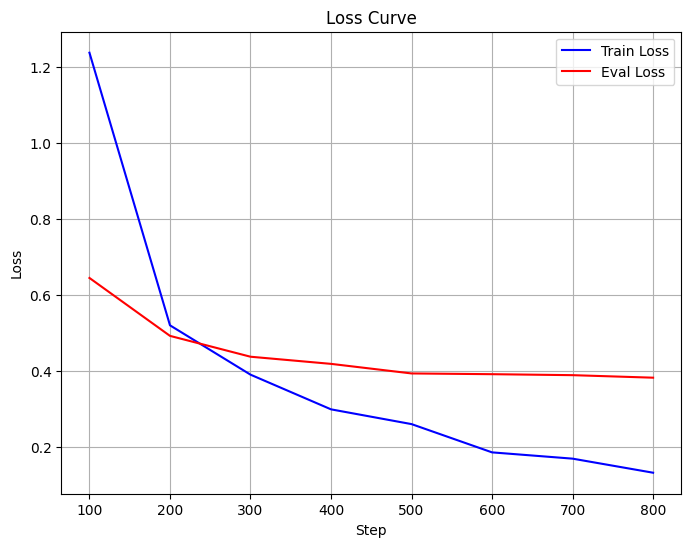

In [15]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

ea = event_accumulator.EventAccumulator('./logs')
ea.Reload()

print("Available tags:", ea.Tags()['scalars'])

# Detect tag names
tags = ea.Tags()['scalars']
train_tag = 'train/loss' if 'train/loss' in tags else 'loss' if 'loss' in tags else None
eval_tag = 'eval/loss' if 'eval/loss' in tags else None

plt.figure(figsize=(8, 6))

# Plot train loss
if train_tag:
    train_loss = ea.Scalars(train_tag)
    steps, values = zip(*[(x.step, x.value) for x in train_loss])
    plt.plot(steps, values, label='Train Loss', color='blue')

# Plot eval loss
if eval_tag:
    eval_loss = ea.Scalars(eval_tag)
    steps_eval, values_eval = zip(*[(x.step, x.value) for x in eval_loss])
    plt.plot(steps_eval, values_eval, label='Eval Loss', color='red')

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import torch
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Load processor from base model
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")

# Load fine-tuned model
model = WhisperForConditionalGeneration.from_pretrained("/kaggle/working/whisper-phoneme-finetune/checkpoint-500")

# Disable forced_decoder_ids in model config to fix ValueError
# model.config.forced_decoder_ids = None
model.generation_config.forced_decoder_ids = None  # Also reset in generation_config

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()
# forced_decoder_ids = processor.get_decoder_prompt_ids(language="en", task="transcribe")


# Load and preprocess audio
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    # Ensure mono audio
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    return waveform.squeeze(0)

# Transcribe audio
def transcribe(audio_path):
    waveform = load_audio(audio_path)
    inputs = processor(waveform, sampling_rate=16000, return_tensors="pt")
    input_features = inputs.input_features.to(device)
    
    # Using generate with safe parameters
    with torch.no_grad():
        predicted_ids = model.generate(
        input_features,
    )
    print(predicted_ids)
    
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=False)[0]
    return transcription

# Example usage
audio_file = "/kaggle/input/voicedata/cv-corpus-20.0-delta-2024-12-06/en/clips/common_voice_en_41247202.mp3"
output_text = transcribe(audio_file)
print("Transcription:", output_text)

tensor([[23436,   133,   103,    82,   276,   135,   230,   569,   133,   103,
            82,   220,   135,   230,   133,   242,   135,   238, 11784,  7250,
           134,   232,   261,   133,   103,    89,   297,   135,   230,    64,
           134,   232,    77,    89,   293,   256,   135,   230,   133,   249,
            74,  7250,    83,   135,   234,    68,   133,   103,    79,   133,
           117,  7250,    75,   297,   135,   230,    64,   134,   232]],
       device='cuda:0')
Transcription: ðɪs hˈapɪs ˈɔːlsəʊ wɪz nˈaʊnz and tˈɛkətˌeɪpɹəl nˈaʊ


In [26]:
!zip -r /kaggle/working/whisper-phoneme-finetune.zip /kaggle/working/whisper-phoneme-finetune/checkpoint-500


  adding: kaggle/working/whisper-phoneme-finetune/checkpoint-500/ (stored 0%)
  adding: kaggle/working/whisper-phoneme-finetune/checkpoint-500/rng_state.pth (deflated 25%)
  adding: kaggle/working/whisper-phoneme-finetune/checkpoint-500/training_args.bin (deflated 51%)
  adding: kaggle/working/whisper-phoneme-finetune/checkpoint-500/optimizer.pt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 8%)
  adding: kaggle/working/whisper-phoneme-finetune/checkpoint-500/generation_config.json (deflated 71%)
  adding: kaggle/working/whisper-phoneme-finetune/checkpoint-500/config.json (deflated 60%)
  adding: kaggle/working/whisper-phoneme-finetune/checkpoint-500/scheduler.pt (deflated 56%)
  adding: kaggle/working/whisper-phoneme-finetune/checkpoint-500/model.safetensors (deflated 19%)
  adding: kaggle/working/whisper-phoneme-finetune/checkpoint-500/scaler.pt (deflated 60%)
  adding: kaggle/working/whisper-phoneme-finetune/checkpoint-500/trainer_state.json (deflated 71%)


In [1]:
pip install ctranslate2 transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 40.3 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ctranslate2[cuda]


Note: you may need to restart the kernel to use updated packages.


In [3]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("/kaggle/input/whisper-phoneme/transformers/tiny/1/kaggle/working/whisper-phoneme-finetune/checkpoint-840")
model.save_pretrained("final_model")

2025-05-20 10:02:31.312954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747735351.574727      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747735351.645085      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from transformers import WhisperProcessor

# Load the processor again (same as you used for training)
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")  # or your custom model
processor.save_pretrained("/kaggle/working/final_model")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

[]

In [8]:
!ct2-transformers-converter \
  --model /kaggle/working/final_model \
  --output_dir /kaggle/working/faster-whisper-int8 \
  --quantization int8 \
  --copy_files generation_config.json


2025-05-20 10:13:23.604627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747736003.626157     123 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747736003.632859     123 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
!pip install faster-whisper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 52.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 98.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.5 MB/s eta 0:00:00


In [11]:
from faster_whisper import WhisperModel

# Load your int8-converted model
model = WhisperModel(
    model_size_or_path="/kaggle/working/faster-whisper-int8",  # or your actual output path
    compute_type="int8",  # or "int8_float16", "float16", etc.
)

# Transcribe an audio file
segments, info = model.transcribe(
    "/kaggle/input/voicedata/cv-corpus-20.0-delta-2024-12-06/en/clips/common_voice_en_41247202.mp3",  # change to your actual file path
    language="en",                        # force English transcription
    beam_size=5,                          # beam search for accuracy
    best_of=5,                            # top candidate choice
    vad_filter=True                       # optional: apply voice activity detection
)

# Collect and print output
full_text = ""
for segment in segments:
    print(f"[{segment.start:.2f}s -> {segment.end:.2f}s] {segment.text}")
    full_text += segment.text.strip() + " "

print("\nFinal transcription:\n", full_text.strip())


ValueError: Requested int8 compute type, but the target device or backend do not support efficient int8 computation.

In [13]:
import shutil

# Path to your Faster-Whisper converted model
source_dir = "/kaggle/working/faster-whisper-int8"  # change this to your actual folder

# Output zip file path (it will be created at /kaggle/working)
output_zip = "/kaggle/working/faster-whisper-int8.zip"

# Create the zip file
shutil.make_archive(output_zip.replace(".zip", ""), 'zip', source_dir)

print("Model zipped successfully:", output_zip)


Model zipped successfully: /kaggle/working/faster-whisper-int8.zip
